In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("Frogs_MFCCs.csv")
target_col = 'Family'

In [3]:
num_cols = df.select_dtypes(include=[np.number]).columns

## 1) Зниження розмірності і візуалізація даних

In [4]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [41]:
# підготовка даних
le = LabelEncoder()
y = le.fit_transform(df[target_col])
X = df[num_cols]

# масштабування (важливо для PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=56)

In [42]:
import time
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# функція для тренування та оцінки
def train_evaluate(X_train, X_test, y_train, y_test, name):
    svc = SVC(random_state=56, C=10, gamma="scale")
    
    start_time = time.time()
    svc.fit(X_train, y_train)
    end_time = time.time()
    
    y_pred = svc.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    duration = end_time - start_time
    
    print(f"[{name}]")
    print(f"  Час навчання: {duration:.5f} сек")
    print(f"  Точність:     {acc:.5f}")
    print(f"  Кількість ознак: {X_train.shape[1]}")
    return acc, duration

In [43]:
print("Навчання на початкових даних")
acc_orig, time_orig = train_evaluate(X_train, X_test, y_train, y_test, "Original Data")

Навчання на початкових даних
[Original Data]
  Час навчання: 0.09700 сек
  Точність:     0.99792
  Кількість ознак: 23


In [44]:
from sklearn.decomposition import PCA

In [45]:
print("PCA (Зниження розмірності)")
# залишаємо 95% дисперсії
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

acc_pca, time_pca = train_evaluate(X_train_pca, X_test_pca, y_train, y_test, "PCA Data")

PCA (Зниження розмірності)
[PCA Data]
  Час навчання: 0.07771 сек
  Точність:     0.99722
  Кількість ознак: 13


In [46]:
print(f"Кількість компонент скоротилася з {X_train.shape[1]} до {X_train_pca.shape[1]}.")
print(f"Зміна точності: {(acc_pca - acc_orig):.5f}")
print(f"Прискорення часу: {(time_orig / time_pca):.2f}x разів")

Кількість компонент скоротилася з 23 до 13.
Зміна точності: -0.00069
Прискорення часу: 1.25x разів


Кількість ознак скоротилася майже вдвічі (з 23 до 13), зберігши при цьому 95% інформації (дисперсії). Це свідчить про те, що багато початкових MFCC коефіцієнтів сильно корелюють між собою (несуть дубльовану інформацію). Час навчання зменшився в 1.25 рази (з 0.097с до 0.077с). На великих обсягах даних це дало б колосальну економію ресурсів. Втрата точності склала менше 0.1%. Це означає, що ті 5% відкинутої дисперсії були здебільшого "шумом", який не допомагав моделі розрізняти класи.

In [11]:
from sklearn.manifold import TSNE

In [12]:
tsne = TSNE(n_components=2, random_state=56)
X_tsne = tsne.fit_transform(X_scaled)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

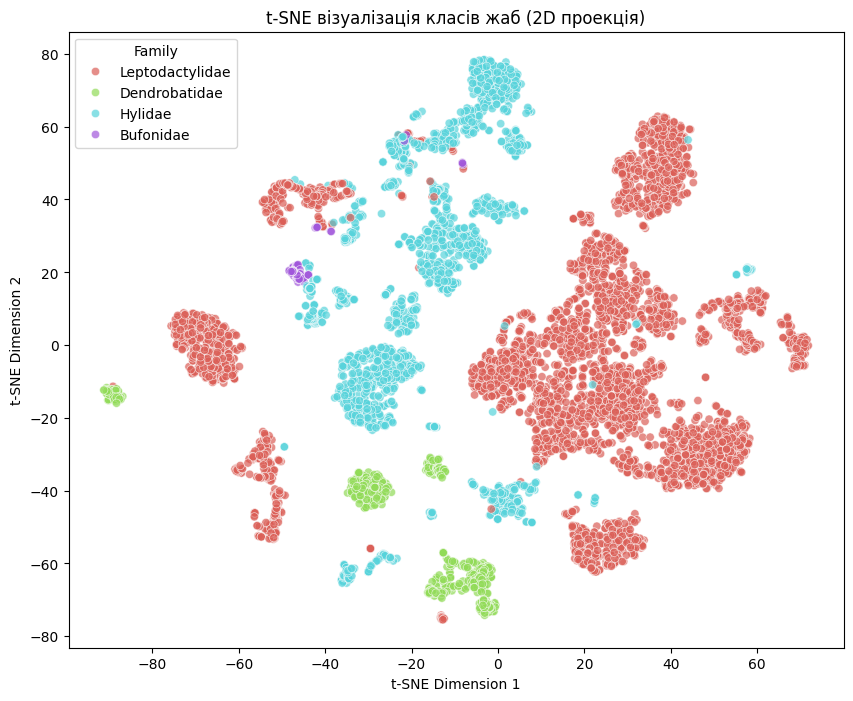

In [14]:
# створюємо DataFrame для зручного плотінгу
tsne_df = pd.DataFrame(data=X_tsne, columns=['Dim_1', 'Dim_2'])
tsne_df['Family'] = df['Family'].values

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Dim_1', y='Dim_2',
    hue='Family',
    palette=sns.color_palette("hls", 4),
    data=tsne_df,
    legend="full",
    alpha=0.7
)
plt.title('t-SNE візуалізація класів жаб (2D проекція)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

Точки різних кольорів (класів) згруповані в окремі кластери і майже не змішуються між собою. Червоні (Leptodactylidae) та Блакитні (Hylidae) формують великі, щільні масиви, які чітко відокремлені один від одного пробілами. Зелені (Dendrobatidae) згруповані в дуже компактні та ізольовані кластери, що робить їх легкими для класифікації. Алгоритм t-SNE проектує багатовимірний простір (23 виміри) у 2D. Той факт, що навіть у 2D ми бачимо чіткі межі між групами, означає, що у початковому просторі ознак ці класи знаходяться далеко один від одного математично. Це пояснює, чому прості алгоритми (як kNN або Random Forest) дають таку високу точність - їм легко провести межі між цими групами. Один колір (наприклад, червоний або блакитний) розбитий на кілька окремих острівців, а не зібраний в одну купу. Це нормально для t-SNE і може свідчити про те, що всередині однієї родини жаб (Family) є підгрупи (різні види або роди), які мають дещо відмінні акустичні характеристики.

## 2) Кластерний аналіз

In [15]:
from PIL import Image

In [16]:
pil_image = Image.open("frog.jpg")
original_img = np.asarray(pil_image)

In [17]:
# нормалізація значень кольору для коректної роботи KMeans
original_img = np.array(original_img, dtype=np.float64) / 255

In [18]:
w, h, d = original_img.shape
print(f"Розмір зображення: {w}x{h}, канали: {d}")

Розмір зображення: 675x1200, канали: 3


In [19]:
# перетворення зображення в 2D масив (список пікселів), де кожен рядок - це колір (R, G, B)
image_array = np.reshape(original_img, (w * h, d))

In [20]:
# функція для квантування
def recreate_image(codebook, labels, w, h):
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

In [21]:
# кількість кольорів для тестування
n_colors_list = [64, 32, 16, 8]

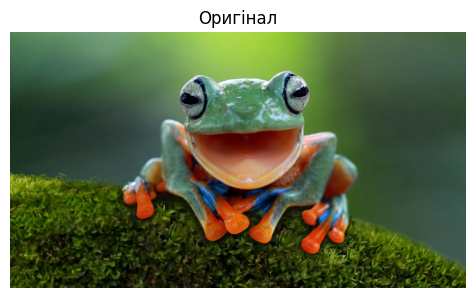

In [22]:
plt.figure(figsize=(20, 12))
plt.subplot(2, 3, 1)
plt.axis("off")
plt.title("Оригінал")
plt.imshow(original_img)

In [23]:
from sklearn.cluster import KMeans

Обробка k=64 кольорів...
Обробка k=32 кольорів...
Обробка k=16 кольорів...
Обробка k=8 кольорів...


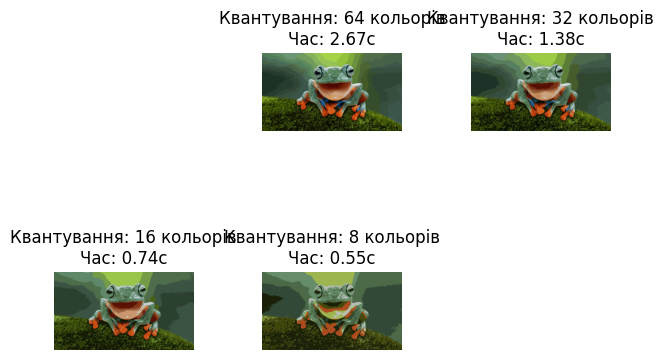

In [24]:
for i, n_colors in enumerate(n_colors_list):
    print(f"Обробка k={n_colors} кольорів...")
    start_t = time.time()
    
    # навчання KMeans на вибірці
    kmeans = KMeans(n_clusters=n_colors, random_state=56)
    kmeans.fit(image_array)
    
    # прогнозування кластерів для пікселів зображення
    labels = kmeans.predict(image_array)
    
    # відновлення зображення
    quantized_img = recreate_image(kmeans.cluster_centers_, labels, w, h)
    end_t = time.time()
    
    # відображення
    plt.subplot(2, 3, i+2)
    plt.axis('off')
    plt.title(f'Квантування: {n_colors} кольорів\nЧас: {end_t-start_t:.2f}с')
    plt.imshow(quantized_img)

plt.tight_layout(pad=3.0, h_pad=3.0, w_pad=5.0)
plt.show()

## 3) Обробка та класифікація текстових даних

In [25]:
sentiment_df = pd.read_csv("tweets.csv")

In [26]:
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [27]:
sentiment_df = sentiment_df[["airline_sentiment", "airline_sentiment_confidence", "airline", "text"]]

In [28]:
print(f"Розмір датасету: {sentiment_df.shape}")
print(sentiment_df.head())

Розмір датасету: (14640, 4)
  airline_sentiment  airline_sentiment_confidence         airline  \
0           neutral                        1.0000  Virgin America   
1          positive                        0.3486  Virgin America   
2           neutral                        0.6837  Virgin America   
3          negative                        1.0000  Virgin America   
4          negative                        1.0000  Virgin America   

                                                text  
0                @VirginAmerica What @dhepburn said.  
1  @VirginAmerica plus you've added commercials t...  
2  @VirginAmerica I didn't today... Must mean I n...  
3  @VirginAmerica it's really aggressive to blast...  
4  @VirginAmerica and it's a really big bad thing...  


### Передобробка тексту

In [29]:
import nltk
from nltk.corpus import stopwords


nltk.download("stopwords", quiet=True)

True

In [30]:
import re

In [31]:
stop_words = set(stopwords.words("english"))

def clean_text(text):
    # приведення до нижнього регістру
    text = text.lower()
    # видалення згадок користувачів (@user)
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    # видалення символів, що не є словами (пунктуація, цифри)
    text = re.sub(r'[^a-z\s]', '', text)
    # видалення зайвих пробілів
    text = re.sub(r'\s+', ' ', text).strip()
    # видалення стоп-слів
    words = text.split()
    filtered_words = [w for w in words if w not in stop_words and len(w) > 2]
    return " ".join(filtered_words)

# застосовуємо очищення
sentiment_df["clean_text"] = sentiment_df["text"].apply(clean_text)

In [32]:
sentiment_df.head()

,airline_sentiment,airline_sentiment_confidence,airline,text,clean_text
0,neutral,1.0000,Virgin America,@VirginAmerica What @dhepburn said.,said
1,positive,0.3486,Virgin America,@VirginAmerica plus you've added commercials t...,plus youve added commercials experience tacky
2,neutral,0.6837,Virgin America,@VirginAmerica I didn't today... Must mean I n...,didnt today must mean need take another trip
3,negative,1.0000,Virgin America,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,negative,1.0000,Virgin America,@VirginAmerica and it's a really big bad thing...,really big bad thing


### WordCloud

In [33]:
from wordcloud import WordCloud

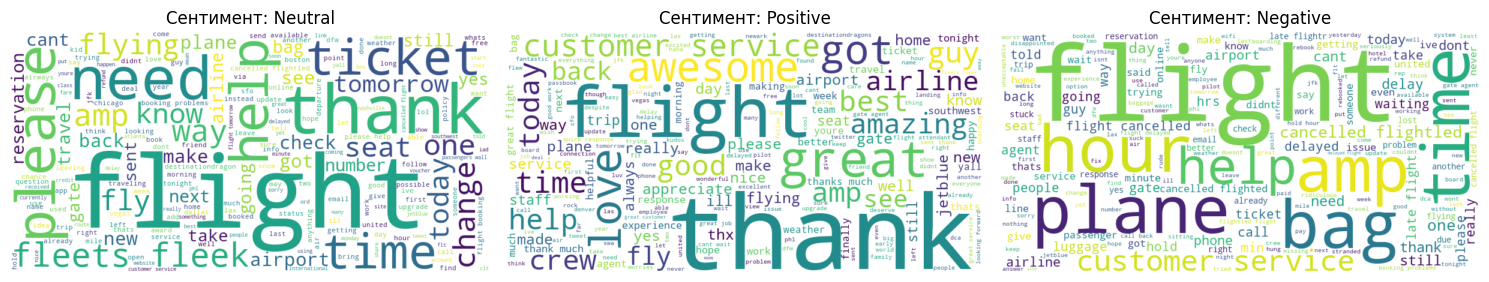

In [34]:
sentiments = sentiment_df["airline_sentiment"].unique()

plt.figure(figsize=(15, 5))

for i, sentiment in enumerate(sentiments):
    # фільтруємо текст за класом
    subset = sentiment_df[sentiment_df["airline_sentiment"] == sentiment]
    text_combined = " ".join(subset["clean_text"])
    
    if not text_combined:
        continue # пропускаємо, якщо порожньо
        
    # створюємо WordCloud
    wc = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_combined)
    
    plt.subplot(1, 3, i+1)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Сентимент: {sentiment.capitalize()}')

plt.tight_layout()
plt.show()

### Векторизація та класифікація

In [35]:
X = sentiment_df["clean_text"]
y = sentiment_df["airline_sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [37]:
vectorizer = TfidfVectorizer()

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f"Розмір словника ознак: {len(vectorizer.get_feature_names_out())}")

Розмір словника ознак: 11775


In [38]:
model = LogisticRegression()
model.fit(X_train_vec, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [39]:
y_pred = model.predict(X_test_vec)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7865

Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.95      0.87      1822
     neutral       0.69      0.46      0.55       619
    positive       0.83      0.60      0.69       487

    accuracy                           0.79      2928
   macro avg       0.77      0.67      0.70      2928
weighted avg       0.78      0.79      0.77      2928



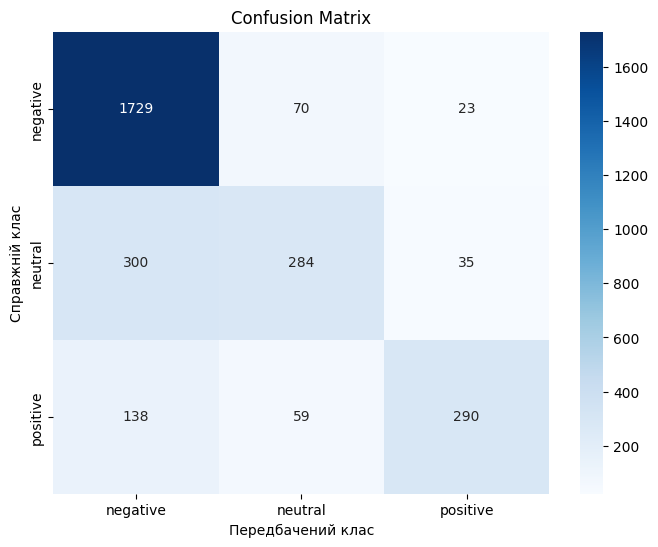

In [40]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Справжній клас')
plt.xlabel('Передбачений клас')
plt.show()